In [ ]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import keras
import tensorflow as tf
from keras import optimizers
from keras.layers import Conv2D, Dense, Dropout, Flatten, Input, concatenate
from keras.layers import MaxPooling2D, BatchNormalization, Activation
from keras.models import Model, Sequential
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint

### Train Data Load

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [ ]:
# Train Data Load
path = '/gdrive/My Drive/'  # 각자의 컴퓨터에 따라 달라질 수 있음

X_train = np.load(path + 'x_train.npy')
y_train = np.load(path + 'y_train.npy')
y_train = to_categorical(y_train)

# Split (8:2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((20000, 32, 32, 3), (20000, 10), (5000, 32, 32, 3), (5000, 10))

In [ ]:
# Image Augmentation (추가적인 Arguments 참조: https://keras.io/api/preprocessing/image/)
datagen = ImageDataGenerator(
    horizontal_flip=True,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    )

### Network Build

In [ ]:
# Modules
def inception_module(input, channel):
    x0 = Conv2D(channel//6, (1, 1), padding='same', activation='relu')(input)

    x1 = Conv2D(channel//6, (1, 1), padding='same', activation='relu')(input)
    x1 = Conv2D(channel//6, (3, 3), padding='same', activation='relu')(x1)

    x2 = Conv2D(channel//6, (1, 1), padding='same', activation='relu')(input)
    x2 = Conv2D(channel//6, (5, 5), padding='same', activation='relu')(x2)

    x3 = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(input)
    x3 = Conv2D(channel//4, (1, 1), padding='same', activation='relu')(x3)

    output = concatenate([x0, x1, x2, x3], axis=3)
    return output

# Basic Convolution Block
def Conv_block(input, channel, padding='same', residual=False):
    x = Conv2D(channel, (3, 3), padding=padding)(input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x


In [ ]:
!nvidia-smi

Fri May 28 07:11:46 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Network Build

with tf.device('gpu:5'):
    start = time.time()
    input_tensor = Input(shape=(32, 32, 3))
    x = Conv_block(input_tensor, channel=32, residual=True)
    x = Conv_block(x, channel=64, padding='valid')
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)
    x = Dropout(0.2)(x)
    
    x = Conv_block(x, channel=128, padding='valid')
    x = Conv_block(x, channel=256, padding='valid')
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)
    x = Dropout(0.3)(x)
    
    x = Conv_block(x, channel=128, padding='valid')
    x = Conv_block(x, channel=64, padding='valid')
    x = MaxPooling2D((1, 1), strides=(2, 2))(x)
    x = Dropout(0.4)(x)
   
    x = inception_module(x, channel=128)

    x = Flatten(input_shape=x.shape[1:])(x)

    x = Dense(512, activation='relu')(x)
    x = Dropout(0.4)

    output_tensor = Dense(10, activation='softmax')(x)

    model = Model(inputs=input_tensor, outputs=output_tensor)

    # model.summary()

    model.compile(loss='categorical_crossentropy',
                optimizer=optimizers.Adam(lr=0.001, decay=0),
                metrics=['accuracy'])
    
    checkpoint_path = "cifar_checkpoint.ckpt"
    checkpoint = ModelCheckpoint(filepath=checkpoint_path,
                                 save_weights_only=True,
                                 save_best_only=True, 
                                 monitor='val_loss', 
                                 verbose=1)
    
    history = model.fit(datagen.flow(X_train, y_train, batch_size=64), 
                        validation_data=(X_val, y_val), epochs=120, callbacks=[checkpoint])
    
    model.load_weights(checkpoint_path)

    print(f'Total Process time:{(time.time() - start)/60}M')


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/120
313/313 [==============================] - 50s 41ms/step - loss: 1.9519 - accuracy: 0.2742 - val_loss: 2.1255 - val_accuracy: 0.3490

Epoch 00001: val_loss improved from inf to 2.12547, saving model to cifar_checkpoint.ckpt
Epoch 2/120
313/313 [==============================] - 11s 35ms/step - loss: 1.4899 - accuracy: 0.4594 - val_loss: 1.8219 - val_accuracy: 0.4310

Epoch 00002: val_loss improved from 2.12547 to 1.82190, saving model to cifar_checkpoint.ckpt
Epoch 3/120
313/313 [==============================] - 11s 36ms/step - loss: 1.3264 - accuracy: 0.5224 - val_loss: 1.4498 - val_accuracy: 0.4766

Epoch 00003: val_loss improved from 1.82190 to 1.44985, saving model to cifar_checkpoint.ckpt
Epoch 4/120
313/313 [==============================] - 11s 36ms/step - loss: 1.2117 - accuracy: 0.5709 - val_loss: 1.9404 - val_accuracy: 0.4480

Epoch 00004: val_loss did not improve from 1.44985
Epoch 5/120
313/313 [==============================] - 11s 36ms/step - loss: 1.1085 - a

### Visualize Training Logs

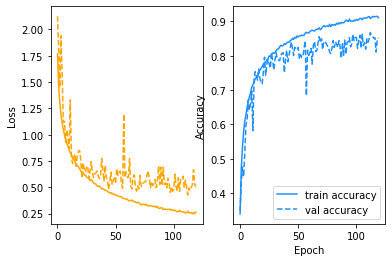

In [ ]:
# Save logs
fig, ax = plt.subplots(1, 2)
ax[0].plot(history.history['loss'],
         label='train loss',
         c='orange', ls='-')
ax[0].plot(history.history['val_loss'],
         label='val loss',
         c='orange',ls='--')
ax[0].set_ylabel('Loss')

ax[1].plot(history.history['accuracy'],
         label='train accuracy',
         c='dodgerblue', ls='-')
ax[1].plot(history.history['val_accuracy'],
         label='val accuracy',
         c='dodgerblue', ls='--')
ax[1].set_ylabel('Accuracy')

plt.xlabel('Epoch')
plt.legend(loc='lower right')
# plt.savefig('Training Logs.png')
plt.show()

### Predict testset & Make submission file

In [ ]:
# Test set load
X_test = np.load(path + 'x_test.npy')
print('Test set Shape:', X_test.shape)

# 가장 확률이 높은 클래스 예측
pred = np.argmax(model.predict(X_test), axis=1)
print('예측 결과 Shape:', pred.shape)

# 제출 결과 파일 생성
idx = np.arange(len(pred))
submission = pd.DataFrame({'id':idx, 'Category':pred})
submission.to_csv('submission3.csv', index=False)

Test set Shape: (35000, 32, 32, 3)
예측 결과 Shape: (35000,)


In [ ]:
submission.head()

,id,Category
0,0,3
1,1,4
2,2,0
3,3,6
4,4,4
